In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT_numbers_replaced_with_at_sign/train/train.txt
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/dev.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/test.txt
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/dev.txt
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/train.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/test.csv
/kaggle/input/pubmed-200k-rtc/PubMed_200k_RCT/train/train.txt
/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/dev.csv
/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/test.txt
/kaggle/input/pubmed-200k-rtc/PubMed_20k_

In [2]:
dataset_dir = "/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/"

In [3]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

In [4]:
# Load the data
train_data = get_raw_data(dataset_dir + 'train.txt')

In [5]:
train_data[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

**Data Preprocessing**

In [6]:
def preprocess_raw_data(filepath):
    raw_data = get_raw_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in raw_data:
        if line.startswith('###'): # check if current line is an abstract start (line -> ###[abstract_id]\n)
            abstract_id = int(line.replace('###', '').replace('\n', '')) # get abstract id
            abstract_data = ''

        elif line.isspace(): # check if current line is an abstract end (line -> '\n')
            abstract_data_split = abstract_data.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {} # store lines in dictionary
                target_text_split = abstract_line.split("\t") # split target label from text 
                
                line_data["abstract_id"] = abstract_id # get abstract id
                #line_data["line_id"] = f'{abstract_id}_{abstract_line_number}_{len(abstract_data_split)}' # create id for each line
                line_data["abstract_text"] = target_text_split[1] # get target text and lower it
                line_data["line_number"] = abstract_line_number # get line number in the abstract
                line_data["total_lines"] = len(abstract_data_split) # get total count for abstract lines (counter starts at 1)
                line_data['current_line'] = f'{abstract_line_number}_{len(abstract_data_split)}' # embed line_number & total_lines into one feature 
                line_data["target"] = target_text_split[0] # get target label
                
                abstract_samples.append(line_data) # append line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line is a abstract text line (line -> [TARGET]\t[abstract_text])
            abstract_data += line

    return abstract_samples

In [7]:
# Get train data from file and preprocess it
train_samples = preprocess_raw_data(dataset_dir + "train.txt")

In [8]:
# Get dev/validation data from file and preprocess it
val_samples = preprocess_raw_data(dataset_dir + "dev.txt")

In [9]:
# Get test data from file and preprocess it
test_samples = preprocess_raw_data(dataset_dir + "test.txt")

In [10]:
train_count = len(train_samples)
val_count = len(val_samples)
test_count = len(test_samples)
total = train_count + val_count + test_count

In [11]:
print(f'train samples count:\t\t{train_count}')
print(f'validation samples count:\t{val_count}')
print(f'test samples count:\t\t{test_count}')

print(f'\ntotal samples:\t\t\t{total}')

train samples count:		180040
validation samples count:	30212
test samples count:		30135

total samples:			240387


In [12]:
# View first 10 abstracts from the train set
train_samples[:10]

[{'abstract_id': 24293578,
  'abstract_text': 'To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12,
  'current_line': '0_12',
  'target': 'OBJECTIVE'},
 {'abstract_id': 24293578,
  'abstract_text': 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 12,
  'current_line': '1_12',
  'target': 'METHODS'},
 {'abstract_id': 24293578,
  'abstract_text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12,
  'current_line': '2_12',
  'target': 'METHODS'},
 {'abstract_id': 24293578,
  'abstract_

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [14]:
# View the first 20 samples in train_df
train_df.head(20)

,abstract_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,To investigate the efficacy of 6 weeks of dail...,0,12,0_12,OBJECTIVE
1,24293578,A total of 125 patients with primary knee OA w...,1,12,1_12,METHODS
2,24293578,Outcome measures included pain reduction and i...,2,12,2_12,METHODS
3,24293578,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS
4,24293578,Secondary outcome measures included the Wester...,4,12,4_12,METHODS
5,24293578,"Serum levels of interleukin 1 ( IL-1 ) , IL-6 ...",5,12,5_12,METHODS
6,24293578,There was a clinically relevant reduction in t...,6,12,6_12,RESULTS
7,24293578,The mean difference between treatment arms ( 9...,7,12,7_12,RESULTS
8,24293578,"Further , there was a clinically relevant redu...",8,12,8_12,RESULTS
9,24293578,These differences remained significant at 12 w...,9,12,9_12,RESULTS


In [15]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["abstract_text"].tolist()
val_sentences = val_df["abstract_text"].tolist()
test_sentences = test_df["abstract_text"].tolist()

In [17]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

print(f'Train samples count:\t\t{train_sentences_count}')
print(f'Dev/Validation sample count:\t{val_sentences_count}')
print(f'Test sample count:\t\t{test_sentences_count}')
print(f'Total samples:\t\t\t{total_sentences_count}')

Train samples count:		180040
Dev/Validation sample count:	30212
Test sample count:		30135
Total samples:			240387


In [18]:
# View first 5 lines of train sentences
train_sentences[:5]

['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .']

In [19]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [21]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [22]:
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [23]:
# inspect label encoded targets
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 5
Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


In [25]:
import tensorflow as tf

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [27]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

**Transfer Learning**

In [28]:
import tensorflow_hub as hub

In [29]:
universal_sentence_encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                            trainable=False,
                                            name="universal_sentence_encoder")

In [30]:
import random
random_sentence = random.choice(train_sentences)
print(random_sentence)
print(f"After USN:\n{universal_sentence_encoder([random_sentence])[0][:30]}")

Using data from a randomized clinical trial that compared 24-hour fluid resuscitation outcomes in critically injured trauma patients treated with 0.9 % sodium chloride injection and those who received a balanced electrolyte solution ( Plasma-Lyte A , Baxter Healthcare ) , a cost-minimization analysis was performed at a large medical center .
After USN:
[-0.07107928  0.04861818 -0.0446657  -0.0385913   0.0596225  -0.02557026
  0.05156393 -0.02774617  0.05960952 -0.02115341  0.07611728 -0.0272899
  0.05452969 -0.02139345 -0.01959429 -0.00647797 -0.07611967  0.05143035
 -0.05955177  0.02552325 -0.01037417 -0.02770649  0.01783739 -0.03746935
  0.03791925 -0.06445411 -0.06009379  0.06705325 -0.05596912 -0.04363234]


In [31]:
inputs = tf.keras.Input(shape=[], dtype=tf.string)
x = universal_sentence_encoder(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
modelUSN = tf.keras.Model(inputs, outputs, name="model_USN")

In [32]:
modelUSN.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [33]:
modelUSN.summary()

Model: "model_USN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,830,981
Trainable params: 33,157
Non-trainable params: 256,797,824
_________________________________________________________________


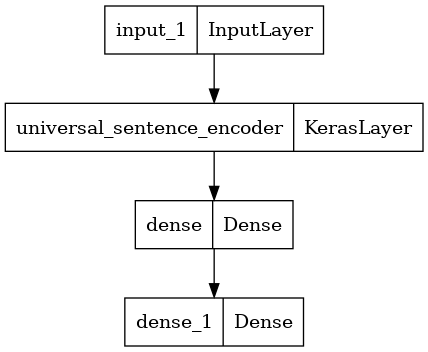

In [34]:
tf.keras.utils.plot_model(modelUSN)

In [35]:
historyUSN = modelUSN.fit(train_dataset,
                              epochs=10,
                              steps_per_epoch=round(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=round(0.1*len(train_dataset)))

Epoch 1/10
563/563 [==============================] - 15s 20ms/step - loss: 0.9280 - accuracy: 0.6483 - val_loss: 0.7744 - val_accuracy: 0.7021
Epoch 2/10
563/563 [==============================] - 11s 19ms/step - loss: 0.7547 - accuracy: 0.7074 - val_loss: 0.7325 - val_accuracy: 0.7213
Epoch 3/10
563/563 [==============================] - 11s 20ms/step - loss: 0.7430 - accuracy: 0.7149 - val_loss: 0.7253 - val_accuracy: 0.7226
Epoch 4/10
563/563 [==============================] - 11s 19ms/step - loss: 0.7199 - accuracy: 0.7263 - val_loss: 0.7063 - val_accuracy: 0.7317
Epoch 5/10
563/563 [==============================] - 11s 19ms/step - loss: 0.7229 - accuracy: 0.7220 - val_loss: 0.6941 - val_accuracy: 0.7360
Epoch 6/10
563/563 [==============================] - 11s 19ms/step - loss: 0.7199 - accuracy: 0.7249 - val_loss: 0.6818 - val_accuracy: 0.7396
Epoch 7/10
563/563 [==============================] - 11s 19ms/step - loss: 0.6905 - accuracy: 0.7370 - val_loss: 0.6736 - val_accuracy:

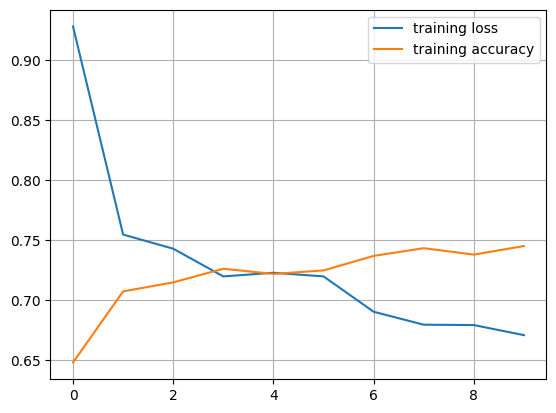

In [36]:
import matplotlib.pyplot as plt
plt.plot(historyUSN.history['loss'], label = 'training loss')
plt.plot(historyUSN.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

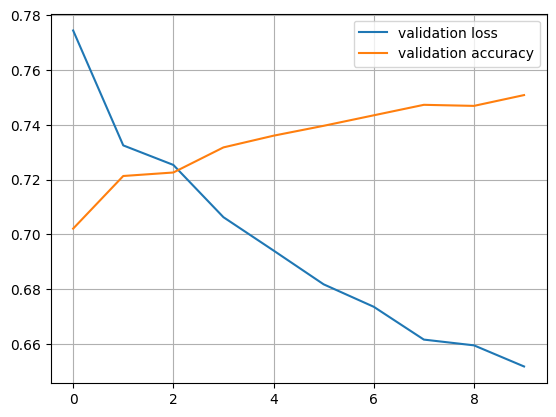

In [37]:
plt.plot(historyUSN.history['val_loss'], label = 'validation loss')
plt.plot(historyUSN.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [38]:
modelUSN.evaluate(test_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.6602 - accuracy: 0.7492


[0.6602023243904114, 0.7491725087165833]

In [39]:
model_1_pred_probs = modelUSN.predict(test_dataset)
model_1_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[4.35999423e-01, 3.91072541e-01, 1.28350256e-03, 1.57206684e-01,
        1.44378962e-02],
       [4.79695350e-01, 3.93961906e-01, 3.24515882e-03, 1.21387176e-01,
        1.71042269e-03],
       [3.65338176e-01, 8.01497251e-02, 9.61178914e-03, 5.32432258e-01,
        1.24680828e-02],
       ...,
       [6.37385063e-04, 6.82960614e-04, 3.64148468e-02, 1.89400598e-04,
        9.62075412e-01],
       [3.58204311e-03, 1.52002778e-02, 2.37089217e-01, 9.45698121e-04,
        7.43182719e-01],
       [6.61037117e-02, 7.59635210e-01, 1.49390459e-01, 3.23675154e-03,
        2.16338467e-02]], dtype=float32)

In [40]:
model_1_pred = tf.argmax(model_1_pred_probs, axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [41]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
def calculate_results(y_true, y_pred):
    """
    returns a dictionary of accuracy_score, precission, recall and f1_score
    """
    precission, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    acc_score = accuracy_score(y_true, y_pred) * 100
    
    results = {
        "accuracy_score": acc_score,
        "precission": precission,
        "recall": recall,
        "f1_score": f1_score
    }
    return results

In [42]:
model_1_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_1_pred)
model_1_results

{'accuracy_score': 74.91725142327552,
 'precission': 0.7433095255925973,
 'recall': 0.7491725142327552,
 'f1_score': 0.7446308330218074}

In [97]:
from sklearn.metrics import confusion_matrix
cmUSN = confusion_matrix(test_labels_encoded,model_1_pred)
cmUSN

array([[1878,  730,  363,  361,  117],
       [ 531, 2870,  345,  115,  721],
       [ 189,  168, 8403,  112, 1092],
       [ 566,  319,  300, 1108,   83],
       [  64,  350, 1038,   14, 8375]])

In [43]:
train_df["length"]=train_df["abstract_text"].apply(lambda x: len(x.split(" ")))

In [44]:
train_df['length']

0         49
1         27
2         15
3         14
4         35
          ..
180035    95
180036    28
180037    18
180038    30
180039    21
Name: length, Length: 180040, dtype: int64

In [45]:
import numpy as  np
max_vocab_length=len(train_df["abstract_text"])
max_length=int(np.percentile(train_df["length"],95))
text_vectorizer=tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,output_sequence_length=max_length)

In [46]:
max_vocab_length

180040

In [47]:
text_vectorizer.adapt(train_sentences)

In [48]:
embedding=tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),output_dim=128,mask_zero=True)
#input length vocabulary
#output 128
#mask_Zero

In [49]:
embedding(text_vectorizer(train_sentences[0])) #Our data is ready to train

<tf.Tensor: shape=(55, 128), dtype=float32, numpy=
array([[ 0.03474841,  0.04992712, -0.03845532, ..., -0.04536294,
        -0.00389038, -0.03795924],
       [ 0.040936  , -0.02720043,  0.00786753, ...,  0.01615032,
         0.02104079, -0.03879565],
       [ 0.04430033, -0.02365897, -0.00946902, ..., -0.02015654,
        -0.01029395,  0.02695943],
       ...,
       [ 0.04114537,  0.00252274, -0.04942515, ..., -0.01782693,
         0.04324813,  0.00019131],
       [ 0.04114537,  0.00252274, -0.04942515, ..., -0.01782693,
         0.04324813,  0.00019131],
       [ 0.04114537,  0.00252274, -0.04942515, ..., -0.01782693,
         0.04324813,  0.00019131]], dtype=float32)>

In [50]:
lr=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))
es=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

In [51]:
inputs=tf.keras.layers.Input(shape=[],dtype="string",name="input layer")
x=text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.LSTM(32)(x)
x=tf.keras.layers.Dropout(0.5)(x)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
modelLSTM=tf.keras.Model(inputs,output,name="modelLSTM")

In [52]:
modelLSTM.summary()

Model: "modelLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           11411456  
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 output (Dense)              (None, 5)                 165       
                                                         

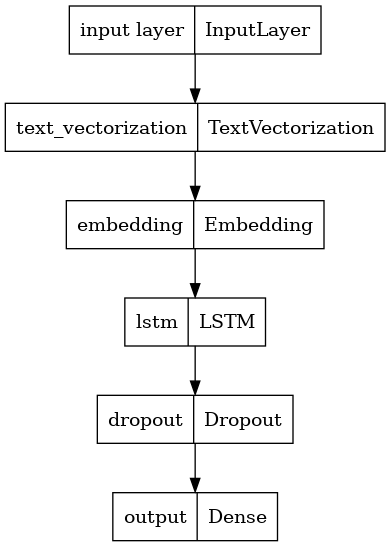

In [53]:
tf.keras.utils.plot_model(modelLSTM)

In [54]:
modelLSTM.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [55]:
import time
startLSTM=time.time()
historyLSTM=modelLSTM.fit(train_dataset,epochs=3,validation_data=val_dataset,callbacks=[es])
endLSTM=time.time()

Epoch 1/3
5627/5627 [==============================] - 108s 18ms/step - loss: 0.6339 - accuracy: 0.7687 - val_loss: 0.5044 - val_accuracy: 0.8190
Epoch 2/3
5627/5627 [==============================] - 55s 10ms/step - loss: 0.4473 - accuracy: 0.8462 - val_loss: 0.5097 - val_accuracy: 0.8214
Epoch 3/3
5627/5627 [==============================] - 56s 10ms/step - loss: 0.3437 - accuracy: 0.8841 - val_loss: 0.5743 - val_accuracy: 0.8126


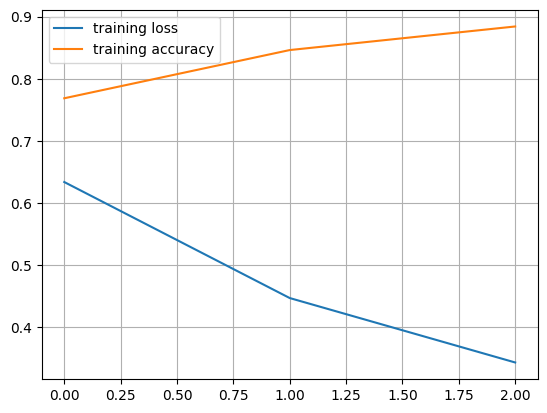

In [56]:
plt.plot(historyLSTM.history['loss'], label = 'training loss')
plt.plot(historyLSTM.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

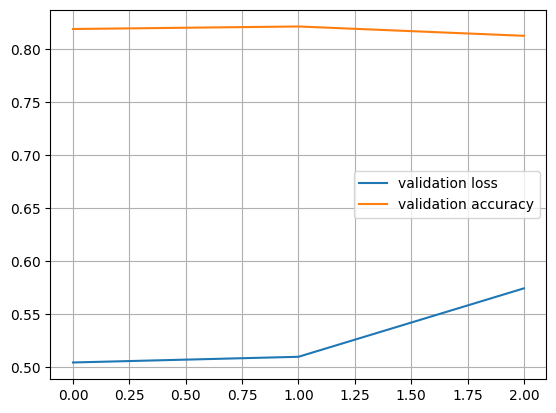

In [57]:
plt.plot(historyLSTM.history['val_loss'], label = 'validation loss')
plt.plot(historyLSTM.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [58]:
modelLSTM.evaluate(test_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5743 - accuracy: 0.8126


[0.5743213891983032, 0.812591016292572]

In [59]:
modelLSTM_pred_probs = modelLSTM.predict(test_dataset)
modelLSTM_pred_probs

945/945 [==============================] - 4s 3ms/step


array([[6.9066393e-01, 6.7697845e-02, 3.0908883e-02, 2.0209140e-01,
        8.6379442e-03],
       [2.9611799e-01, 5.4337174e-01, 1.4585888e-03, 1.4634407e-01,
        1.2707589e-02],
       [5.4754591e-01, 4.0484057e-03, 3.2013480e-03, 4.4485697e-01,
        3.4736251e-04],
       ...,
       [9.7482007e-07, 2.4685008e-04, 3.0654619e-04, 4.7567329e-07,
        9.9944514e-01],
       [4.4894181e-03, 9.0792936e-01, 1.1185026e-03, 1.2102815e-03,
        8.5252501e-02],
       [9.8223044e-03, 9.8293096e-01, 2.4411856e-04, 1.0569477e-03,
        5.9456974e-03]], dtype=float32)

In [60]:
modelLSTM_pred = tf.argmax(modelLSTM_pred_probs, axis=1)
modelLSTM_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 1, 1])>

In [61]:
modelLSTM_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=modelLSTM_pred)
modelLSTM_results

{'accuracy_score': 81.2591023434397,
 'precission': 0.8120616885950597,
 'recall': 0.8125910234343969,
 'f1_score': 0.8106254615074725}

In [96]:
cmLSTM = confusion_matrix(test_labels_encoded,modelLSTM_pred)
cmLSTM

array([[2315,  438,  298,  351,   47],
       [ 520, 3266,  147,   40,  609],
       [ 148,   83, 8856,   63,  814],
       [ 787,  162,  138, 1262,   27],
       [  42,  391,  549,    8, 8851]])

**GRU**

In [62]:
inputs=tf.keras.layers.Input(shape=[],dtype="string",name="input layer")
x=text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.GRU(128)(x)
x=tf.keras.layers.Dense(128,activation="relu")(x)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
modelGRU=tf.keras.Model(inputs,output,name="modelGRU")

In [63]:
modelGRU.summary()

Model: "modelGRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           11411456  
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 output (Dense)              (None, 5)                 645       
                                                          

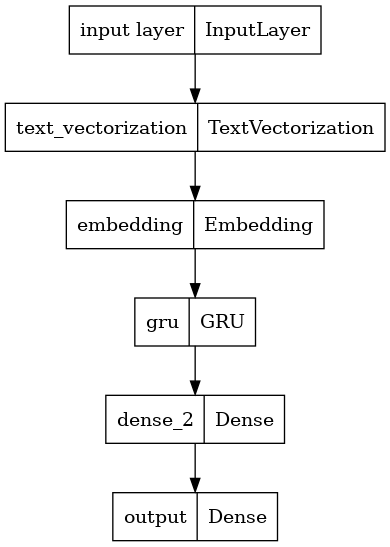

In [64]:
tf.keras.utils.plot_model(modelGRU)

In [65]:
modelGRU.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [66]:
startGru=time.time()
historyGRU=modelGRU.fit(train_dataset,epochs=3,validation_data=val_dataset,callbacks=[es])
endGRU=time.time()

Epoch 1/3
5627/5627 [==============================] - 93s 16ms/step - loss: 0.3066 - accuracy: 0.8928 - val_loss: 0.6310 - val_accuracy: 0.8059
Epoch 2/3
5627/5627 [==============================] - 56s 10ms/step - loss: 0.1966 - accuracy: 0.9335 - val_loss: 0.8069 - val_accuracy: 0.7917
Epoch 3/3
5627/5627 [==============================] - 56s 10ms/step - loss: 0.1384 - accuracy: 0.9533 - val_loss: 0.9653 - val_accuracy: 0.7915


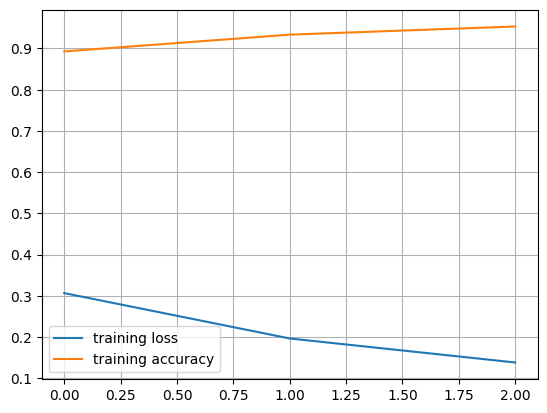

In [67]:
plt.plot(historyGRU.history['loss'], label = 'training loss')
plt.plot(historyGRU.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

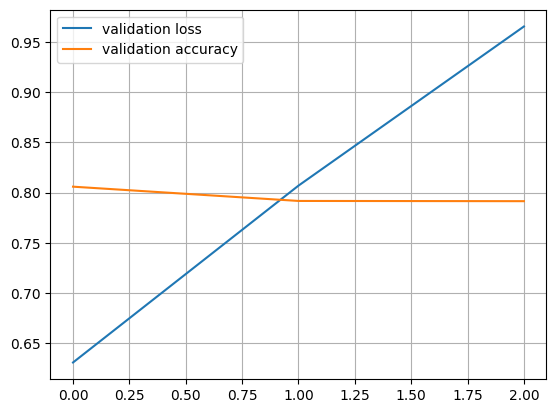

In [68]:
plt.plot(historyGRU.history['val_loss'], label = 'validation loss')
plt.plot(historyGRU.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [69]:
modelGRU.evaluate(test_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.9653 - accuracy: 0.7915


[0.9653253555297852, 0.7914735674858093]

In [70]:
modelGRU_pred_probs = modelGRU.predict(test_dataset)
modelGRU_pred_probs

945/945 [==============================] - 4s 3ms/step


array([[9.5785666e-01, 8.5080750e-03, 4.3410528e-04, 3.2504067e-02,
        6.9710944e-04],
       [8.9289707e-01, 6.0105692e-03, 3.5699493e-08, 1.0109216e-01,
        2.4413958e-07],
       [2.9389755e-04, 6.9502477e-07, 8.8043635e-09, 9.9970537e-01,
        5.2145523e-09],
       ...,
       [6.4781074e-07, 1.5913340e-04, 1.3846374e-04, 2.8236107e-07,
        9.9970144e-01],
       [2.6232563e-06, 9.9696916e-01, 1.7064312e-07, 2.7213373e-06,
        3.0254535e-03],
       [6.6072686e-04, 9.9622273e-01, 7.1387967e-06, 4.7538160e-05,
        3.0617884e-03]], dtype=float32)

In [71]:
modelGRU_pred = tf.argmax(modelGRU_pred_probs, axis=1)
modelGRU_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [72]:
modelGRU_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=modelGRU_pred)
modelGRU_results

{'accuracy_score': 79.14735866543096,
 'precission': 0.7907061275580488,
 'recall': 0.7914735866543096,
 'f1_score': 0.7909438271124944}

In [95]:
cmGRU = confusion_matrix(test_labels_encoded,modelGRU_pred)
cmGRU

array([[2085,  428,  296,  581,   59],
       [ 538, 3188,  146,  154,  556],
       [ 196,  127, 8856,  125,  660],
       [ 683,  151,  136, 1377,   29],
       [  44,  535,  828,   28, 8406]])

**Word2Vec**

In [73]:
word2vec=tf.keras.layers.Embedding(max_vocab_length,
                                      128,
                                      input_length=[],
                                      name="w2v_embedding")

In [74]:
inputs=tf.keras.layers.Input(shape=[],dtype="string",name="input layer")
x=text_vectorizer(inputs)
x=word2vec(x)
x=tf.keras.layers.Dense(256,activation="relu")(x)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
output=tf.keras.layers.Dense(5,activation="softmax",name="output")(x)
modelword2vec=tf.keras.Model(inputs,output,name="modelw2v")

In [75]:
modelword2vec.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [76]:
modelword2vec.summary()

Model: "modelw2v"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 w2v_embedding (Embedding)   (None, 55, 128)           23045120  
                                                                 
 dense_3 (Dense)             (None, 55, 256)           33024     
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 output (Dense)              (None, 5)                 128

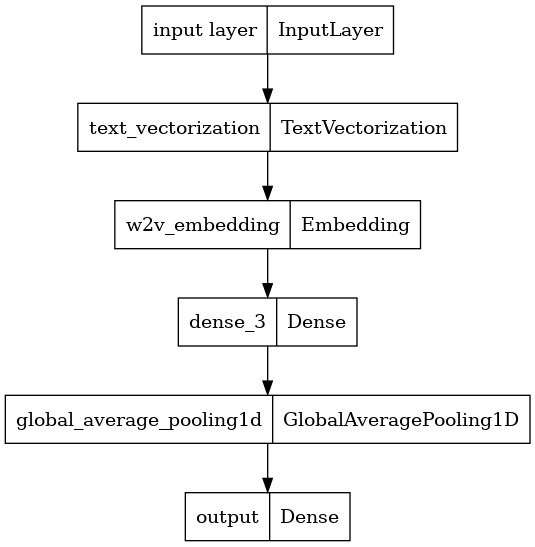

In [77]:
tf.keras.utils.plot_model(modelword2vec)

In [78]:
startw2v=time.time()
historyword2vec=modelword2vec.fit(train_dataset,epochs=5,validation_data=val_dataset,callbacks=[es])
endw2v=time.time()

Epoch 1/5
5627/5627 [==============================] - 84s 15ms/step - loss: 0.6296 - accuracy: 0.7669 - val_loss: 0.5563 - val_accuracy: 0.8016
Epoch 2/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.4740 - accuracy: 0.8337 - val_loss: 0.5643 - val_accuracy: 0.8012
Epoch 3/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.3974 - accuracy: 0.8652 - val_loss: 0.6084 - val_accuracy: 0.7923
Epoch 4/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.3400 - accuracy: 0.8871 - val_loss: 0.6757 - val_accuracy: 0.7823


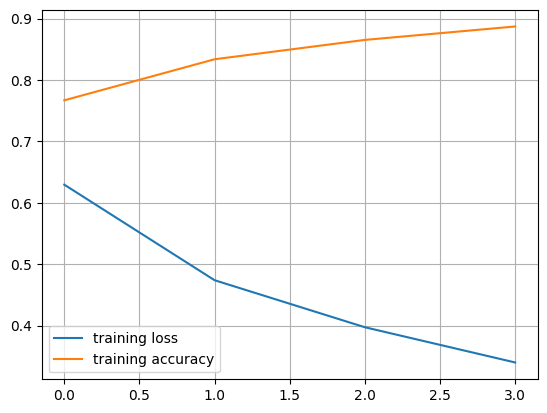

In [79]:
plt.plot(historyword2vec.history['loss'], label = 'training loss')
plt.plot(historyword2vec.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

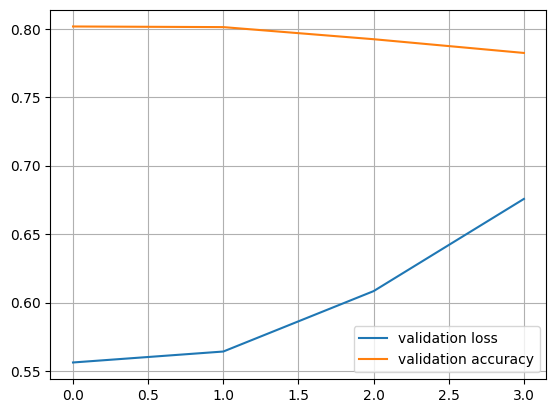

In [80]:
plt.plot(historyword2vec.history['val_loss'], label = 'validation loss')
plt.plot(historyword2vec.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [81]:
modelword2vec.evaluate(test_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6757 - accuracy: 0.7823


[0.6757287979125977, 0.7823050618171692]

In [82]:
modelword2vec_pred_probs = modelword2vec.predict(test_dataset)
modelword2vec_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[1.84942618e-01, 1.32443635e-02, 2.71587133e-01, 5.26383966e-02,
        4.77587461e-01],
       [6.15093470e-01, 4.29849774e-02, 6.81907265e-03, 3.27545851e-01,
        7.55659584e-03],
       [4.56673950e-02, 2.39656205e-04, 7.21136457e-05, 9.54019666e-01,
        1.09859752e-06],
       ...,
       [1.93923233e-09, 2.31945720e-07, 2.42992910e-03, 2.39736522e-07,
        9.97569621e-01],
       [1.28947319e-02, 2.32094765e-01, 6.04354143e-01, 1.94693487e-02,
        1.31187052e-01],
       [2.25202758e-02, 9.75682378e-01, 1.11244479e-03, 3.09288531e-04,
        3.75622243e-04]], dtype=float32)

In [83]:
modelword2vec_pred = tf.argmax(modelword2vec_pred_probs, axis=1)
modelword2vec_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([4, 0, 3, ..., 4, 2, 1])>

In [84]:
modelword2vec_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=modelword2vec_pred)
modelword2vec_results

{'accuracy_score': 78.23050443532371,
 'precission': 0.7788734768454759,
 'recall': 0.7823050443532371,
 'f1_score': 0.7800042908970578}

In [85]:
w2v = confusion_matrix(test_labels_encoded,modelword2vec_pred)
w2v

array([[1974,  523,  314,  551,   87],
       [ 435, 3171,  175,  145,  656],
       [ 170,  131, 8496,  140, 1027],
       [ 677,  238,  164, 1246,   51],
       [  42,  394,  625,   32, 8748]])

In [86]:
!pip install transformers 
!pip install torch 

In [87]:
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("pritamdeka/BioBert-PubMed200kRCT")
tokenizer = AutoTokenizer.from_pretrained("pritamdeka/BioBert-PubMed200kRCT")
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
#pipe("Treatment of 12 healthy female subjects with CDCA for 2 days resulted in increased BAT activity.")

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [88]:
results = pipe(val_sentences[:1000])

print(f'\n{results}')


[[{'label': 'BACKGROUND', 'score': 0.9334680438041687}, {'label': 'CONCLUSIONS', 'score': 0.004035759251564741}, {'label': 'METHODS', 'score': 0.0011191567173227668}, {'label': 'OBJECTIVE', 'score': 0.06117338314652443}, {'label': 'RESULTS', 'score': 0.00020377596956677735}], [{'label': 'BACKGROUND', 'score': 0.7750213742256165}, {'label': 'CONCLUSIONS', 'score': 0.018660200759768486}, {'label': 'METHODS', 'score': 0.0014882403193041682}, {'label': 'OBJECTIVE', 'score': 0.20408976078033447}, {'label': 'RESULTS', 'score': 0.0007404432981275022}], [{'label': 'BACKGROUND', 'score': 0.09424808621406555}, {'label': 'CONCLUSIONS', 'score': 0.00036204545176588}, {'label': 'METHODS', 'score': 0.0018660050118342042}, {'label': 'OBJECTIVE', 'score': 0.9034019112586975}, {'label': 'RESULTS', 'score': 0.00012189907283755019}], [{'label': 'BACKGROUND', 'score': 0.0005569786881096661}, {'label': 'CONCLUSIONS', 'score': 2.1847125026397407e-05}, {'label': 'METHODS', 'score': 0.9963961243629456}, {'la

In [89]:
max_label=[]
for y in results:
    max_label.append(max(y, key=lambda x: x['score'])['label'])

In [90]:
max_label

['BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 

In [91]:
val_actual=[]
for x in val_df["target"]:
    val_actual.append(x)

In [92]:
from sklearn.metrics import accuracy_score


# Calculate accuracy
accuracy = accuracy_score(val_actual[0:1000], max_label)

print(f"Accuracy: {accuracy}")


Accuracy: 0.937


In [93]:
print("\nModelUSN:",model_1_results)
print("\nModelLSTM:",modelLSTM_results)
print("\nModelWord2Vec:",modelword2vec_results)
print("\nModelGRU:",modelGRU_results)


ModelUSN: {'accuracy_score': 74.91725142327552, 'precission': 0.7433095255925973, 'recall': 0.7491725142327552, 'f1_score': 0.7446308330218074}

ModelLSTM: {'accuracy_score': 81.2591023434397, 'precission': 0.8120616885950597, 'recall': 0.8125910234343969, 'f1_score': 0.8106254615074725}

ModelWord2Vec: {'accuracy_score': 78.23050443532371, 'precission': 0.7788734768454759, 'recall': 0.7823050443532371, 'f1_score': 0.7800042908970578}

ModelGRU: {'accuracy_score': 79.14735866543096, 'precission': 0.7907061275580488, 'recall': 0.7914735866543096, 'f1_score': 0.7909438271124944}
